In [22]:
import torch
import torch.nn as nn
import torchvision.models as models
import cv2
import numpy as np
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

num_epochs = 30


# DualResNet 클래스 정의
class DualResNet(nn.Module):
    def __init__(self, num_classes=1):
        super(DualResNet, self).__init__()
        # 모델 정의
        weights = ResNet18_Weights.DEFAULT
        self.model1 = resnet18(weights=weights)
        self.model2 = resnet18(weights=weights)
        
        # 마지막 FC 레이어를 제거 (feature extraction만)
        self.model1 = nn.Sequential(*list(self.model1.children())[:-1])
        self.model2 = nn.Sequential(*list(self.model2.children())[:-1])
        
        # 결합된 특징으로부터 최종 예측을 위한 FC 레이어
        self.fc = nn.Linear(512 * 2, num_classes)
    
    def forward(self, img1, img2):
        # 각각의 ResNet 모델을 통해 특징 추출
        feat1 = self.model1(img1)
        feat2 = self.model2(img2)
        
        # (batch_size, 512, 1, 1) 형태의 출력을 (batch_size, 512)로 변환
        feat1 = feat1.view(feat1.size(0), -1)
        feat2 = feat2.view(feat2.size(0), -1)
        
        # 두 특징을 결합
        combined_features = torch.cat((feat1, feat2), dim=1)
        
        # 결합된 특징을 통해 최종 예측
        out = self.fc(combined_features)
        
        return out


In [23]:
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img)
        l = self.clahe.apply(l)
        img = cv2.merge((l, a, b))
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        return Image.fromarray(img)

class GammaCorrection:
    def __init__(self, gamma=1.0):
        self.gamma = gamma
        
    def __call__(self, img):
        img = np.array(img)
        img = img / 255.0
        img = np.power(img, self.gamma)
        img = np.uint8(img * 255)
        return Image.fromarray(img)

class ErodeTransform:
    def __init__(self, kernel_size=(3, 3), iterations=1):
        self.kernel = np.ones(kernel_size, np.uint8)
        self.iterations = iterations

    def __call__(self, img):
        img = np.array(img)
        img = cv2.erode(img, self.kernel, iterations=self.iterations)
        return Image.fromarray(img)

class DilateTransform:
    def __init__(self, kernel_size=(3, 3), iterations=1):
        self.kernel = np.ones(kernel_size, np.uint8)
        self.iterations = iterations

    def __call__(self, img):
        img = np.array(img)
        img = cv2.diate(img, self.kernel, iterations=self.iterations)
        return Image.fromarray(img)
        
class CropLargestSquareTransform:
    def __call__(self, img):
        img = np.array(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 127, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return Image.fromarray(img)
        
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        side_length = max(w, h)
        x_center = x + w // 2
        y_center = y + h // 2
        x1 = max(x_center - side_length // 2, 0)
        y1 = max(y_center - side_length // 2, 0)
        x2 = min(x_center + side_length // 2, img.shape[1])
        y2 = min(y_center + side_length // 2, img.shape[0])
        
        img_cropped = img[y1:y2, x1:x2]
        return Image.fromarray(img_cropped)

class LaplacianTransform:
    def __init__(self):
        # 라플라시안 마스크를 정의합니다.
        self.mask = np.array([[1, 1, 1], 
                              [1, -8, 1], 
                              [1, 1, 1]])

    def __call__(self, original):
        # PIL 이미지를 numpy 배열로 변환
        img = np.array(original)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 라플라시안 필터 적용
        laplacian = cv2.filter2D(img, -1, self.mask)
        img = cv2.cvtColor(laplacian, cv2.COLOR_GRAY2BGR)
        # img = 1 - img
        img = original-img
        # numpy 배열을 다시 PIL 이미지로 변환
        return Image.fromarray(img)
    
class OtsuThresholdTransform:
    def __call__(self, original):
        # PIL 이미지를 numpy 배열로 변환
        img = np.array(original)

        # 이미지를 그레이스케일로 변환
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 오츠 이진화 적용
        _, otsu_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # 이진화된 이미지를 BGR로 변환 (필요한 경우)
        otsu_img_bgr = cv2.cvtColor(otsu_img, cv2.COLOR_GRAY2BGR)
        img = img - otsu_img_bgr
        # numpy 배열을 다시 PIL 이미지로 변환
        return Image.fromarray(img)


Using device: mps
Epoch 1/1, Train Loss: 0.5473, Train Acc: 81.28%, Validation Loss: 2.3576, Validation Acc: 62.50%
Saved final model at dual/final_model.pth


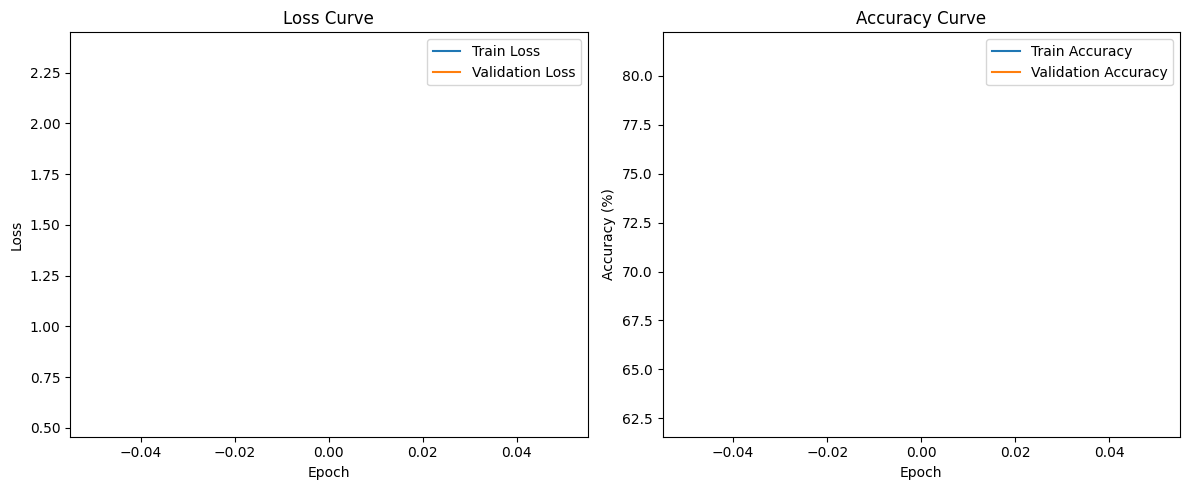

Test Loss: 0.0027, Test Accuracy: 100.00%


In [24]:
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# CUDA 또는 MPS 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# 이미지 크기 설정
IMAGE_SIZE = 224

# Transformations 정의
transform1 = transforms.Compose([
    transforms.Resize((IMAGE_SIZE//2, IMAGE_SIZE//2)),
    # transforms.RandomCrop((IMAGE_SIZE // 2, IMAGE_SIZE // 2)),  
    # LaplacianTransform(),  # 사용자 정의 변환
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    CLAHETransform(clip_limit=5.0, tile_grid_size=(8, 8)),
    GammaCorrection(gamma=0.45),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform2 = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.CenterCrop((IMAGE_SIZE // 2, IMAGE_SIZE // 2)),  
    # LaplacianTransform(),  # 사용자 정의 변환
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    CLAHETransform(clip_limit=5.0, tile_grid_size=(8, 8)),
    GammaCorrection(gamma=0.45),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class DualImageFolder(Dataset):
    def __init__(self, root, transform1=None, transform2=None):
        self.dataset = torchvision.datasets.ImageFolder(root, transform=None)
        self.transform1 = transform1
        self.transform2 = transform2
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        img = Image.open(path).convert('RGB')
        
        img1 = self.transform1(img) if self.transform1 else img
        img2 = self.transform2(img) if self.transform2 else img
        
        return img1, img2, label

# Train, Validation, Test 데이터셋 정의
train_set = DualImageFolder("archive/train", transform1=transform1, transform2=transform2)
val_set = DualImageFolder("archive/valid", transform1=transform1, transform2=transform2)
test_set = DualImageFolder("archive/test", transform1=transform1, transform2=transform2)

# DataLoader 정의
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# DualResNet 모델 정의 (위에서 설명한 DualResNet 클래스를 사용)
model = DualResNet(num_classes=1)  # 이진 분류이므로 출력은 1개
model = model.to(device)

# 손실 함수와 최적화 함수 정의 (이진 분류에 맞게 변경)
criterion = nn.BCEWithLogitsLoss()  # 이진 분류를 위한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실 및 정확도 기록을 위한 리스트
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for img1, img2, labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()  # BCEWithLogitsLoss를 위해 float형으로 변환
        
        optimizer.zero_grad()
        outputs = model(img1, img2).squeeze(1)  # 출력 크기를 맞추기 위해 squeeze 사용
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()  # 0.5를 기준으로 이진 분류
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 검증 단계
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for img1, img2, labels in val_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
            outputs = model(img1, img2).squeeze(1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%')

# 마지막 에포크의 모델 가중치 저장
model_path = 'dual/final_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Saved final model at {model_path}')

# 성능 평가 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# 테스트 데이터셋으로 모델 평가
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for img1, img2, labels in test_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
        outputs = model(img1, img2).squeeze(1)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss /= len(test_loader)
test_acc = 100. * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')